# Entrenamiento del Modelo a partir del dataset limpio

Este notebook esta enfocado en realizar el entrenamiento del modelo

In [2]:
import sys
from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import joblib

# Ruta del directorio del notebook
NOTEBOOK_DIR = Path.cwd()

# La raíz del proyecto está un nivel arriba
ROOT = NOTEBOOK_DIR.parent

sys.path.append(str(ROOT))

from src.utils.config import DATA_DIR, STANDARDIZED_PARQUET_FILE

print("✅ Librerías cargadas.")

✅ Librerías cargadas.


## Carga y Seleccion de Features

In [3]:
print("📦 Cargando dataset estandarizado...")
# Usamos scan_parquet para no cargar todo hasta seleccionar columnas
lf = pl.scan_parquet(STANDARDIZED_PARQUET_FILE)

# ==========================================
# 1. DEFINICIÓN DE FEATURES Y TARGET
# ==========================================

# A. Variables Categóricas (Texto que convertiremos a códigos)
features_cat = [
    "DEPARTAMENTO",
    "MUNICIPIO",
    "TIPO_PREDIO_ZONA",
    "CATEGORIA_RURALIDAD",
    "ORIP",  # Oficina de registro (muy relevante geográficamente)
    "ESTADO_FOLIO",  # Activo/Cerrado puede influir
]

# B. Variables Numéricas (Cantidades y métricas)
features_num = [
    "YEAR_RADICA",  # Año es crítico para la inflación/valor
    "NUM_ANOTACION",  # Historial del predio
    "Dinámica_Inmobiliaria",  # Índice de mercado
    "COD_NATUJUR",  # Naturaleza jurídica (aunque es código, se comporta numéricamente o categórico ordinal)
    "COUNT_A",  # Conteo "A" (De a)
    "COUNT_DE",  # Conteo "DE"
    "PREDIOS_NUEVOS",  # Indicador de novedad
    "TIENE_MAS_DE_UN_VALOR",  # Bandera de complejidad
]

# C. Target (Lo que queremos predecir)
target_col = "RANGO_PRECIO"

# ==========================================
# 2. VALIDACIÓN Y CARGA
# ==========================================

# Lista total de columnas requeridas
required_cols = features_cat + features_num + [target_col]

# Validamos cuáles existen realmente en el archivo físico
schema_cols = lf.collect_schema().names()
existing_cols = [c for c in required_cols if c in schema_cols]
missing_cols = [c for c in required_cols if c not in schema_cols]

if missing_cols:
    print(
        f"⚠️ Advertencia: Las siguientes columnas no se encontraron y serán ignoradas: {missing_cols}"
    )

print(f"✅ Features seleccionados finales ({len(existing_cols) - 1}):")
print(f"   • Categóricos: {[c for c in features_cat if c in existing_cols]}")
print(f"   • Numéricos:   {[c for c in features_num if c in existing_cols]}")

# ==========================================
# 3. RECOLECCIÓN A PANDAS
# ==========================================
print("\n🚀 Cargando datos a memoria RAM...")

# Cargamos todo el dataset (5.7M filas).
# LightGBM necesita Pandas DataFrame.
df = lf.select(existing_cols).collect().to_pandas()

print(f"✓ Dataset cargado exitosamente: {df.shape}")
print(df.head())


📦 Cargando dataset estandarizado...
✅ Features seleccionados finales (14):
   • Categóricos: ['DEPARTAMENTO', 'MUNICIPIO', 'TIPO_PREDIO_ZONA', 'CATEGORIA_RURALIDAD', 'ORIP', 'ESTADO_FOLIO']
   • Numéricos:   ['YEAR_RADICA', 'NUM_ANOTACION', 'Dinámica_Inmobiliaria', 'COD_NATUJUR', 'COUNT_A', 'COUNT_DE', 'PREDIOS_NUEVOS', 'TIENE_MAS_DE_UN_VALOR']

🚀 Cargando datos a memoria RAM...
✓ Dataset cargado exitosamente: (5778058, 15)
  DEPARTAMENTO  MUNICIPIO TIPO_PREDIO_ZONA CATEGORIA_RURALIDAD ORIP  \
0    ANTIOQUIA  ABEJORRAL            RURAL               Rural    2   
1    ANTIOQUIA      AMAGÁ           URBANO          Intermedio   33   
2    ANTIOQUIA      AMAGÁ           URBANO          Intermedio   33   
3    ANTIOQUIA      AMAGÁ           URBANO          Intermedio   33   
4    ANTIOQUIA      AMAGÁ           URBANO          Intermedio   33   

  ESTADO_FOLIO  YEAR_RADICA  NUM_ANOTACION  Dinámica_Inmobiliaria  \
0       ACTIVO         2022           13.0                      1   
1      

## Preprocesamiento (Encoding)

In [4]:
print("⚙️ Preprocesando datos...")

# 1. Codificar Target (RANGO_PRECIO -> 0=BAJO, 1=MEDIO, etc.)
# Usamos LabelEncoder para transformar texto a números
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])

# Guardamos el mapeo para saber qué es qué
target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print(f"🎯 Clases target codificadas: {target_mapping}")

# 2. Optimizar Features Categóricos
# LightGBM funciona mejor y más rápido si las columnas de texto son tipo 'category'
cat_cols_final = [c for c in features_cat if c in df.columns]

print(f"📝 Convirtiendo a categoría: {cat_cols_final}")
for col in cat_cols_final:
    df[col] = df[col].astype("category")

# 3. Separar X (Features) e y (Target)
X = df.drop(columns=[target_col])
y = df[target_col]

# Limpieza de memoria (Importante con 5M de filas)
del df
import gc

gc.collect()

print(f"✓ Datos listos. X shape: {X.shape}, y shape: {y.shape}")

⚙️ Preprocesando datos...
🎯 Clases target codificadas: {'ALTO': np.int64(0), 'BAJO': np.int64(1), 'LUJO': np.int64(2), 'MEDIO': np.int64(3)}
📝 Convirtiendo a categoría: ['DEPARTAMENTO', 'MUNICIPIO', 'TIPO_PREDIO_ZONA', 'CATEGORIA_RURALIDAD', 'ORIP', 'ESTADO_FOLIO']
✓ Datos listos. X shape: (5778058, 14), y shape: (5778058,)


## Split Train / Test

In [5]:
print("✂️ Dividiendo en Train (80%) y Test (20%)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Train set: {X_train.shape[0]:,} filas")
print(f"   Test set:  {X_test.shape[0]:,} filas")

✂️ Dividiendo en Train (80%) y Test (20%)...
   Train set: 4,622,446 filas
   Test set:  1,155,612 filas


## Entrenamiento (LightGBM)

In [6]:
print("🔥 Entrenando Modelo LightGBM...")

# Crear datasets nativos de LightGBM (optimizados para velocidad)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_final)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Hiperparámetros del modelo
params = {
    "objective": "multiclass",  # Clasificación de múltiples clases
    "num_class": len(target_mapping),  # 4 clases
    "metric": "multi_logloss",  # Métrica de error estándar
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "learning_rate": 0.1,  # Velocidad de aprendizaje
    "num_leaves": 31,  # Complejidad de los árboles
    "n_jobs": -1,  # Usar todos los núcleos del procesador
    "verbose": -1,
}

# Entrenar
# num_boost_round=500: Intentará crear 500 árboles
# early_stopping(50): Si no mejora en 50 rondas, se detiene antes
bst = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)],
)

print("✅ Entrenamiento finalizado.")

🔥 Entrenando Modelo LightGBM...
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.697649
[100]	valid_0's multi_logloss: 0.681173
[150]	valid_0's multi_logloss: 0.672112
[200]	valid_0's multi_logloss: 0.666632
[250]	valid_0's multi_logloss: 0.662799
[300]	valid_0's multi_logloss: 0.659338
[350]	valid_0's multi_logloss: 0.65664
[400]	valid_0's multi_logloss: 0.654393
[450]	valid_0's multi_logloss: 0.65244
[500]	valid_0's multi_logloss: 0.650832
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.650832
✅ Entrenamiento finalizado.


In [7]:
print("🔥 Re-Entrenando LightGBM (Balanceado)...")

# 1. Calcular Pesos
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"⚖️ Pesos de clases: {weight_dict}")

# 2. Crear Datasets DESDE CERO (Solución al error)
# Creamos la lista de pesos alineada con y_train
weights_vector = [weight_dict[label] for label in y_train]

# Importante: free_raw_data=False ayuda si vas a reusar, pero aquí recreamos todo
train_data_balanced = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_cols_final,
    weight=weights_vector,
    free_raw_data=False,
)

# El test set debe tener como referencia el NUEVO train set balanceado
test_data_balanced = lgb.Dataset(
    X_test, label=y_test, reference=train_data_balanced, free_raw_data=False
)

# 3. Parámetros y Entrenamiento
params = {
    "objective": "multiclass",
    "num_class": 4,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "n_jobs": -1,
    "verbose": -1,
}

bst_balanced = lgb.train(
    params,
    train_data_balanced,
    valid_sets=[test_data_balanced],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)],
)

print("✅ Re-entrenamiento finalizado.")

🔥 Re-Entrenando LightGBM (Balanceado)...
⚖️ Pesos de clases: {np.int64(0): np.float64(2.619994604080041), np.int64(1): np.float64(0.42591679372910474), np.int64(2): np.float64(18.385062682957873), np.int64(3): np.float64(0.8223336509443293)}
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.946195
[100]	valid_0's multi_logloss: 0.914224
[150]	valid_0's multi_logloss: 0.897927
[200]	valid_0's multi_logloss: 0.887738
[250]	valid_0's multi_logloss: 0.879334
[300]	valid_0's multi_logloss: 0.872999
[350]	valid_0's multi_logloss: 0.867753
[400]	valid_0's multi_logloss: 0.862921
[450]	valid_0's multi_logloss: 0.85897
[500]	valid_0's multi_logloss: 0.854745
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.854745
✅ Re-entrenamiento finalizado.


## Evaluación y Reporte

📊 Evaluando desempeño...

Reporte Detallado:
              precision    recall  f1-score   support

        ALTO       0.58      0.24      0.34    110269
        BAJO       0.79      0.86      0.82    678308
        LUJO       0.80      0.35      0.49     15714
       MEDIO       0.60      0.61      0.61    351321

    accuracy                           0.72   1155612
   macro avg       0.69      0.52      0.56   1155612
weighted avg       0.71      0.72      0.71   1155612



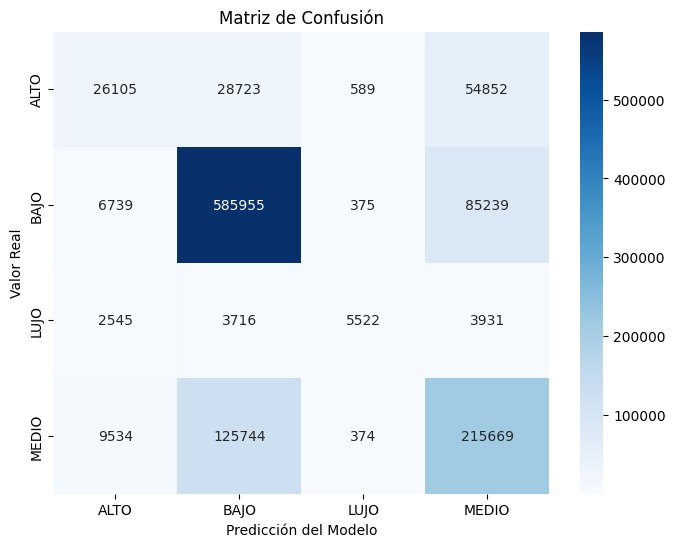

In [8]:
print("📊 Evaluando desempeño...")

# 1. Predecir probabilidades
y_pred_prob = bst.predict(X_test, num_iteration=bst.best_iteration)

# 2. Convertir probabilidad a la clase con mayor puntaje
y_pred = [np.argmax(x) for x in y_pred_prob]

# 3. Reporte de Clasificación
print("\nReporte Detallado:")
print(classification_report(y_test, y_pred, target_names=list(target_mapping.keys())))

# 4. Matriz de Confusión Gráfica
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(target_mapping.keys()),
    yticklabels=list(target_mapping.keys()),
)
plt.xlabel("Predicción del Modelo")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

### Re entrenamiento

📊 Evaluando desempeño (Modelo Balanceado)...

Reporte Detallado:
              precision    recall  f1-score   support

        ALTO       0.30      0.57      0.39    110269
        BAJO       0.86      0.72      0.78    678308
        LUJO       0.15      0.72      0.25     15714
       MEDIO       0.58      0.51      0.55    351321

    accuracy                           0.64   1155612
   macro avg       0.47      0.63      0.49   1155612
weighted avg       0.72      0.64      0.67   1155612



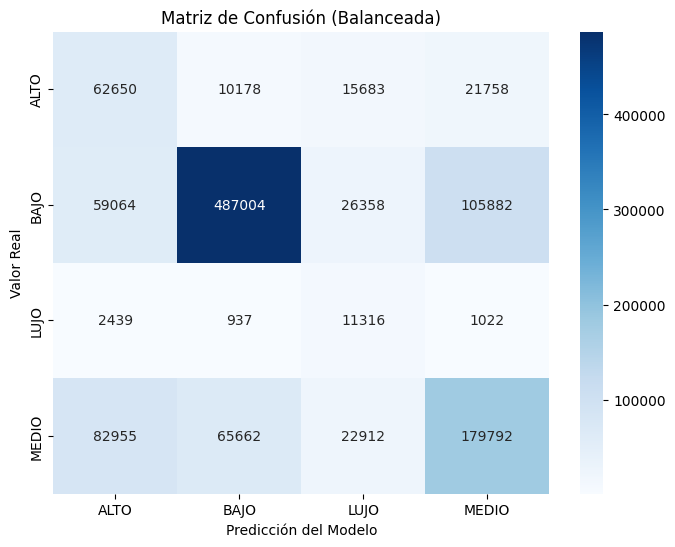

In [9]:
print("📊 Evaluando desempeño (Modelo Balanceado)...")

# 1. Predecir probabilidades usando el modelo balanceado
y_pred_prob = bst_balanced.predict(X_test, num_iteration=bst_balanced.best_iteration)

# 2. Convertir probabilidad a la clase con mayor puntaje
y_pred = [np.argmax(x) for x in y_pred_prob]

# 3. Reporte de Clasificación
print("\nReporte Detallado:")
print(classification_report(y_test, y_pred, target_names=list(target_mapping.keys())))

# 4. Matriz de Confusión Gráfica
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(target_mapping.keys()),
    yticklabels=list(target_mapping.keys()),
)
plt.xlabel("Predicción del Modelo")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión (Balanceada)")
plt.show()

## Importancia de Variables

⭐ Importancia de Variables:


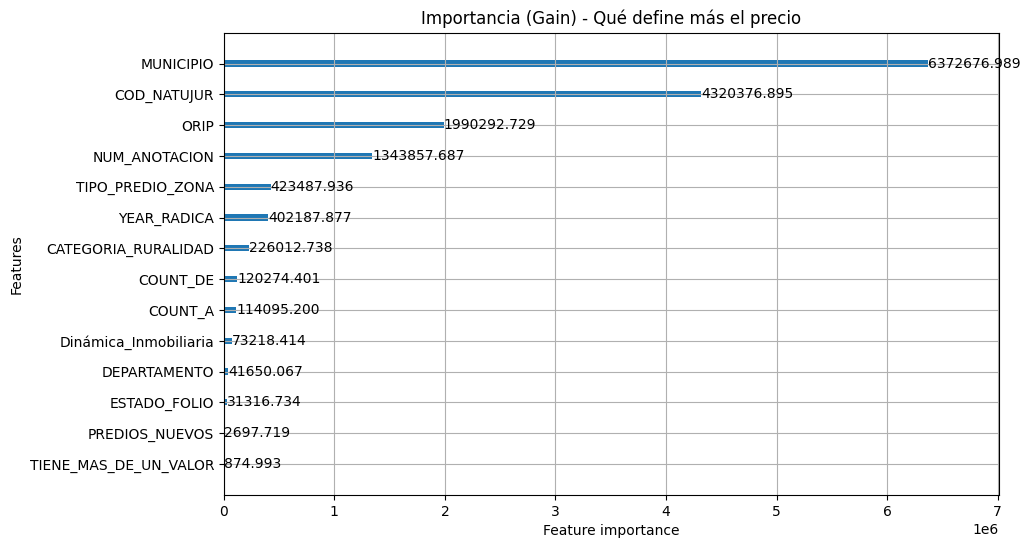

In [10]:
print("⭐ Importancia de Variables:")
lgb.plot_importance(bst, max_num_features=20, importance_type="gain", figsize=(10, 6))
plt.title("Importancia (Gain) - Qué define más el precio")
plt.show()

## Guardar el Modelo

In [11]:
# Definir directorio de modelos (usando pathlib para que sea seguro)
MODELS_DIR = DATA_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)  # Crear carpeta si no existe

print(f"📂 Guardando modelos en: {MODELS_DIR}")

# 1. Guardar el Modelo Balanceado
model_path = MODELS_DIR / "lgbm_classifier_balanced_v1.pkl"
joblib.dump(bst_balanced, model_path)
print(f"💾 Modelo guardado en: {model_path}")

# 2. Guardar los Artefactos
artifacts = {
    "target_classes": le_target.classes_.tolist(),
    "cat_features": cat_cols_final,
    "all_features": bst_balanced.feature_name(),
    "target_mapping": target_mapping,
}

artifacts_path = MODELS_DIR / "model_artifacts_v1.pkl"
joblib.dump(artifacts, artifacts_path)
print(f"💾 Artefactos guardados en: {artifacts_path}")

📂 Guardando modelos en: c:\Users\carlo\Documents\KrozFu\repos\challenge-opendata\igac-anomalias-inmobiliarias\data\models
💾 Modelo guardado en: c:\Users\carlo\Documents\KrozFu\repos\challenge-opendata\igac-anomalias-inmobiliarias\data\models\lgbm_classifier_balanced_v1.pkl
💾 Artefactos guardados en: c:\Users\carlo\Documents\KrozFu\repos\challenge-opendata\igac-anomalias-inmobiliarias\data\models\model_artifacts_v1.pkl
